In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import re

## Load dataframe
I have constructed a dataframe containing 1425 features. <br>
This dataframe takes up a lot of memory and it will take a long time to train models on it. <br>
It is likely that many of these features are redundant and have little informational value, so I will try to shrink down the dataset while losing as little information as possible.

In [4]:
df = pd.read_csv('./dataset_full.csv')

## lightgbm has some problem with some of the names created during feature engineering
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


print(df.shape)
df.head()

(356255, 1470)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,175783.73,175783.73,219625.700,219625.700,219625.690,219625.690,1008781.200,1008781.200,4.172888e+06,4.172888e+06
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1154108.20,1154108.20,1150977.400,1150977.400,1618864.600,1618864.600,4394101.500,4394101.500,1.134881e+07,1.134881e+07
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,16071.75,16071.75,21288.465,21288.465,21288.465,21288.465,31721.895,31721.895,6.386539e+04,6.386539e+04
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,994476.70,994476.70,691786.900,691786.900,1007153.400,1007153.400,1057860.200,1057860.200,3.719995e+06,3.719995e+06
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,483756.38,825845.80,280199.700,294631.120,806127.940,835985.300,836703.400,836703.400,1.139621e+07,1.179154e+07


## Remove features with too many missing values
First of all, I will remove all features where more than 75% of rows contain missing a missing value. <br>
69 features are removed in this way.

In [5]:
missing = pd.DataFrame(df.isnull().sum())
missing['percent'] = 100 * missing / len(df)
missing_columns = list(missing.index[missing['percent'] > 75])
print(len(missing_columns))
df = df.drop(columns=missing_columns)

69


## Remove features with very high collinearity
Secondly, I will remove features with a collinearity over 90%. <br>
Since it will take forever to calculate the correlation matrix on the whole dataset, I use a sample of 20k rows, which should be a close enough proxy. <br>
650 highly collinear features are dropped from the dataset.

In [6]:
corr_matrix = df.sample(20000).corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,1.000000,0.001574,0.002669,0.001312,0.002521,0.002127,0.001246,0.000482,0.015350,0.007013,...,0.001884,0.002837,0.001377,0.000815,0.006122,0.004909,0.008849,0.009112,0.000241,0.000309
TARGET,0.001574,1.000000,0.016110,0.015271,0.029951,0.019545,0.039504,0.038715,0.061354,0.080190,...,0.053970,0.029851,0.004850,0.000197,0.004874,0.001464,0.023147,0.022803,0.002416,0.004490
CNT_CHILDREN,0.002669,0.016110,1.000000,0.010335,0.001231,0.013442,0.003396,0.025760,0.325585,0.070549,...,0.057421,0.054211,0.034363,0.030127,0.046050,0.043753,0.012787,0.013424,0.034095,0.032480
AMT_INCOME_TOTAL,0.001312,0.015271,0.010335,1.000000,0.360260,0.440749,0.368351,0.196287,0.053055,0.039766,...,0.177044,0.201352,0.240285,0.249540,0.220909,0.222292,0.155094,0.156187,0.159557,0.157414
AMT_CREDIT,0.002521,0.029951,0.001231,0.360260,1.000000,0.754069,0.987092,0.114732,0.044208,0.097907,...,0.121604,0.116755,0.180444,0.177980,0.157478,0.151714,0.127587,0.128042,0.109991,0.103463


In [7]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,NaN,0.001574,0.002669,0.001312,0.002521,0.002127,0.001246,0.000482,0.015350,0.007013,...,0.001884,0.002837,0.001377,0.000815,0.006122,0.004909,0.008849,0.009112,0.000241,0.000309
TARGET,NaN,NaN,0.016110,0.015271,0.029951,0.019545,0.039504,0.038715,0.061354,0.080190,...,0.053970,0.029851,0.004850,0.000197,0.004874,0.001464,0.023147,0.022803,0.002416,0.004490
CNT_CHILDREN,NaN,NaN,NaN,0.010335,0.001231,0.013442,0.003396,0.025760,0.325585,0.070549,...,0.057421,0.054211,0.034363,0.030127,0.046050,0.043753,0.012787,0.013424,0.034095,0.032480
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.360260,0.440749,0.368351,0.196287,0.053055,0.039766,...,0.177044,0.201352,0.240285,0.249540,0.220909,0.222292,0.155094,0.156187,0.159557,0.157414
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,0.754069,0.987092,0.114732,0.044208,0.097907,...,0.121604,0.116755,0.180444,0.177980,0.157478,0.151714,0.127587,0.128042,0.109991,0.103463


In [8]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
len(to_drop)

660

In [9]:
df = df.drop(columns=to_drop)
df.shape

(356255, 741)

## Remove features with low importance
Lastly I will remove the features with the lowest importance as given by a boosted random forest.

### Calculate feature importance in LightGBM
With 742 features, the model returns a ROC of 0.7867. A significant improvement over the initial models discussed in the first notebook. <br>
328 features are of no importance and can be safely discarded. A total of 360 features are needed to achieve 95% of the cumulative feature importances. <br>

In [10]:
#X = pd.get_dummies(df[df.test==False].drop(columns = ['SK_ID_CURR', 'TARGET']))

X = df[df.test==False].drop(columns = ['SK_ID_CURR', 'TARGET', 'test'])
y = df.loc[df.test==False, 'TARGET']

In [11]:
cat = list(df.select_dtypes(include=['category', 'object']).columns)
for c in cat:
    X[c] = X[c].astype('category')

In [12]:
feature_importances = np.zeros(X.shape[1])

In [13]:
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 13)

In [15]:
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'auc', categorical_feature = cat,
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_c

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.782981	valid_0's binary_logloss: 0.531692
[200]	valid_0's auc: 0.784519	valid_0's binary_logloss: 0.502342
Early stopping, best iteration is:
[133]	valid_0's auc: 0.784876	valid_0's binary_logloss: 0.520649


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [16]:
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
36,ORGANIZATION_TYPE,473
89,credit_term,138
91,ext_mean,92
25,OCCUPATION_TYPE,67
7,AMT_ANNUITY,65


In [17]:
len(feature_importances.loc[feature_importances.importance == 0.0,'feature'])

310

In [18]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop=True)
feature_importances['norm'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative'] = np.cumsum(feature_importances['norm'])

In [19]:
feature_importances.head()

,feature,importance,norm,cumulative
0,ORGANIZATION_TYPE,473,0.118546,0.118546
1,credit_term,138,0.034586,0.153133
2,ext_mean,92,0.023058,0.176190
3,OCCUPATION_TYPE,67,0.016792,0.192982
4,AMT_ANNUITY,65,0.016291,0.209273


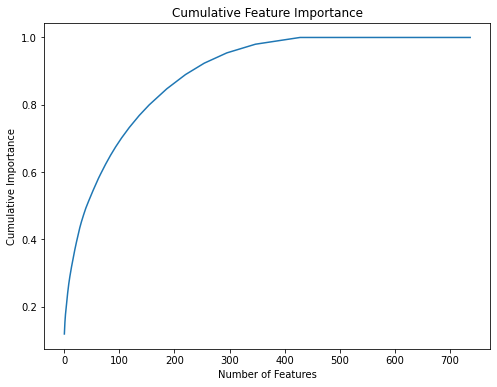

In [20]:
plt.figure(figsize = (8, 6))
plt.plot(feature_importances.index, feature_importances.cumulative)
plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Feature Importance');
plt.show();

In [21]:
for i in [0.8, 0.9, 0.95]:
    print('{} features make up {}% of cumulative importance.'.format(
        len(feature_importances[feature_importances.cumulative < i]),
        i*100
    ))

155 features make up 80.0% of cumulative importance.
231 features make up 90.0% of cumulative importance.
290 features make up 95.0% of cumulative importance.


### Remove low importance features and test model
I reduce the model to the 305 most important features. <br>
The model is now significantly smaller and the accuracy drops only slightly to a ROC 0.7863.

In [23]:
to_drop = list(feature_importances.loc[feature_importances.cumulative > 0.95,'feature'])

In [28]:
df = df.drop(columns=to_drop)

In [29]:
X = df[df.test==False].drop(columns = ['SK_ID_CURR', 'TARGET', 'test'])
y = df.loc[df.test==False, 'TARGET']

In [30]:
cat = list(df.select_dtypes(include=['category', 'object']).columns)
for c in cat:
    X[c] = X[c].astype('category')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 13)

In [33]:
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'auc', categorical_feature = cat,
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.783302	valid_0's binary_logloss: 0.53148
[200]	valid_0's auc: 0.784537	valid_0's binary_logloss: 0.502622
Early stopping, best iteration is:
[144]	valid_0's auc: 0.78487	valid_0's binary_logloss: 0.517924


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [34]:
df.to_csv('dataset_reduced.csv', index = False)